# Visualize embeddings of our model and baselines on test set and validation set

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import opensoundscape as opso

from matplotlib import pyplot as plt
def figsize(w,h):
    plt.rcParams['figure.figsize']=[w,h]
figsize(15,5) #for big visuals
%config InlineBackend.figure_format = 'retina'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# gill sans
plt.rcParams['font.family'] = 'Gill Sans'

import torch
def identity(x):
    return x

# local source code imports
import sys
sys.path.append(f'../../src/')
import evaluation
from preprocessor import OvenbirdPreprocessor
import random
from model import Resnet18_Classifier, ContrastiveResnet18

palette = sns.color_palette("deep") + sns.color_palette("Dark2")

# set seed for reproducibility
random.seed(2024)
np.random.seed(2024)

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_77266/3170153371.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## load individual-level song annotations for the Validation and Test sets
These are annotated Ovenbird songs to individual-level from acoustic localization arrays

In [4]:
# download the public dataset of individually annotated Ovenbird songs from EDI.
# put the path the folder here
labels_dir = "../../../localization_dataset_labeled_clips/"

labels = pd.read_csv(f"{labels_dir}/labeled_clips.csv")

# prepare for prediction
labels["file"] = labels["rel_path"].apply(lambda x: Path(labels_dir) / x)
labels["song_center_time"] = 5  # we have 10s audio clip centered on the annotated song

val_labels = labels[labels["data_split"] == "val"].copy()
test_labels = labels[labels["data_split"] == "test"].copy()

In [5]:
# unzip the HawkEars and BirdNet embeddings if precomputed_embeddings folder doesn't already exist
if not Path("../resources/precomputed_embeddings").exists():
    import zipfile

    with zipfile.ZipFile("../resources/precomputed_embeddings.zip", "r") as zip_ref:
        zip_ref.extractall("../resources/precomputed_embeddings")
    print("Unzipped precomputed embeddings.")

## Generate or load test set embeddings with each model

In [6]:
# load the trained Ovenbird feature extractor model, using GPU device if one is available
ckpt_path = (
    "../../checkpoints/full_2025-04-10T11:02:36.028451_best.pth"  # full_best.pth"
)
# save_dir = "/media/auk/projects/sml161/ecco46_loca_aiid/train_pam/checkpoints"

device = (
    opso.ml.cnn._gpu_if_available()
)  # select MPS or CUDA GPU if available, otherwise CPU
ovenbird_feature_extractor = Resnet18_Classifier(num_classes=234)
ovenbird_feature_extractor.load_state_dict(torch.load(ckpt_path, map_location=device))
ovenbird_feature_extractor.device = device
ovenbird_feature_extractor.to(device)

# create standard preprocessor for Ovenbird song clips
pre = OvenbirdPreprocessor()
pre.pipeline.load_audio.set(load_metadata=False)

models = {
    "ovenbird": ovenbird_feature_extractor,
    "baseline_resnet18": ContrastiveResnet18(),
    "hawkears": None,  # HawkEars embeddings are created separately
    "birdnet": None,  # BirdNet embeddings are created separately
}

test_set_embeddings_paths = {
    "ovenbird": "../resources/precomputed_embeddings/ovenbird_test_embeddings.npy",
    "baseline_resnet18": "../resources/precomputed_embeddings/baseline_resnet18_test_embeddings.npy",
    "hawkears": "../resources/precomputed_embeddings/hawkears_test_embeddings.npy",
    "birdnet": "../resources/precomputed_embeddings/birdnet_test_embeddings.npy",
}

# embed or load embeddings for validation and test sets with each model
test_set_embeddings = {}

for model_name, model in models.items():
    embedding_path = test_set_embeddings_paths[model_name]
    if Path(embedding_path).exists():
        print(f"loading saved {model_name} embeddings for test set")
        test_set_embeddings[model_name] = np.load(embedding_path)
    else:
        print(f"embedding test set samples with {model_name}")
        test_set_embeddings[model_name] = evaluation.embed(
            test_labels, model, pre, batch_size=128, num_workers=0
        )
        np.save(embedding_path, test_set_embeddings[model_name])

loading saved ovenbird embeddings for test set
loading saved baseline_resnet18 embeddings for test set
loading saved hawkears embeddings for test set
loading saved birdnet embeddings for test set


### visualize feature embeddings
We reduce to 2 dimensions instead of 3 for visualization. Note that peformance was equivalent for TSNE with 2 and 3 dimensions in our experiments. 

In [7]:
# standardize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# create 2d features for each model
for i, (model, embeddings) in enumerate(test_set_embeddings.items()):
    features = evaluation.reduce_dims(
        embeddings, reduction_algorithm="tsne", reduced_n_dimensions=2
    )
    features = scaler.fit_transform(features)  # standardize the features
    test_labels[f"{model}_dim1"] = features[:, 0]
    test_labels[f"{model}_dim2"] = features[:, 1]

### Validation set

In [8]:
validation_set_embeddings_paths = {
    "ovenbird": "../resources/precomputed_embeddings/ovenbird_val_embeddings.npy",
    "baseline_resnet18": "../resources/precomputed_embeddings/baseline_resnet18_val_embeddings.npy",
    "hawkears": "../resources/precomputed_embeddings/hawkears_val_embeddings.npy",
    "birdnet": "../resources/precomputed_embeddings/birdnet_val_embeddings.npy",
}

# embed or load embeddings for validation and test sets with each model
validation_set_embeddings = {}

for model_name, model in models.items():
    embedding_path = validation_set_embeddings_paths[model_name]
    if Path(embedding_path).exists():
        print(f"loading saved {model_name} embeddings for validation set")
        validation_set_embeddings[model_name] = np.load(embedding_path)
    else:
        print(f"embedding validation set samples with {model_name}")
        validation_set_embeddings[model_name] = evaluation.embed(
            val_labels, model, pre, batch_size=128, num_workers=0
        )
        np.save(embedding_path, validation_set_embeddings[model_name])

loading saved ovenbird embeddings for validation set
loading saved baseline_resnet18 embeddings for validation set
loading saved hawkears embeddings for validation set
loading saved birdnet embeddings for validation set


### visualize feature embeddings
We reduce to 2 dimensions instead of 3 for visualization. Note that peformance on the validation set was equivalent for TSNE with 2 and 3 dimensions in our experiments, and we used 3 dimensions for the 4-year case study.

In [9]:
# standardize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# create 2d features for each model
for i, (model, embeddings) in enumerate(validation_set_embeddings.items()):
    features = evaluation.reduce_dims(
        embeddings, reduction_algorithm="tsne", reduced_n_dimensions=2
    )
    features = scaler.fit_transform(features)  # standardize the features
    val_labels[f"{model}_dim1"] = features[:, 0]
    val_labels[f"{model}_dim2"] = features[:, 1]

/Users/SML161/miniconda3/envs/opso0110/lib/python3.11/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):
/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_77266/1588384599.py:31: UserWarning: The palette list has more values (30) than needed (15), which may not be intended.
  g = sns.scatterplot(
/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_77266/1588384599.py:31: UserWarning: The palette list has more values (30) than needed (15), which may not be intended.
  g = sns.scatterplot(
/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_77266/1588384599.py:31: UserWarning: The palette list has more values (30) than needed (15), which may not be intended.
  g = sns.scatterplot(
/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_77266/1588384599.py:31: UserWarning: The palette list has

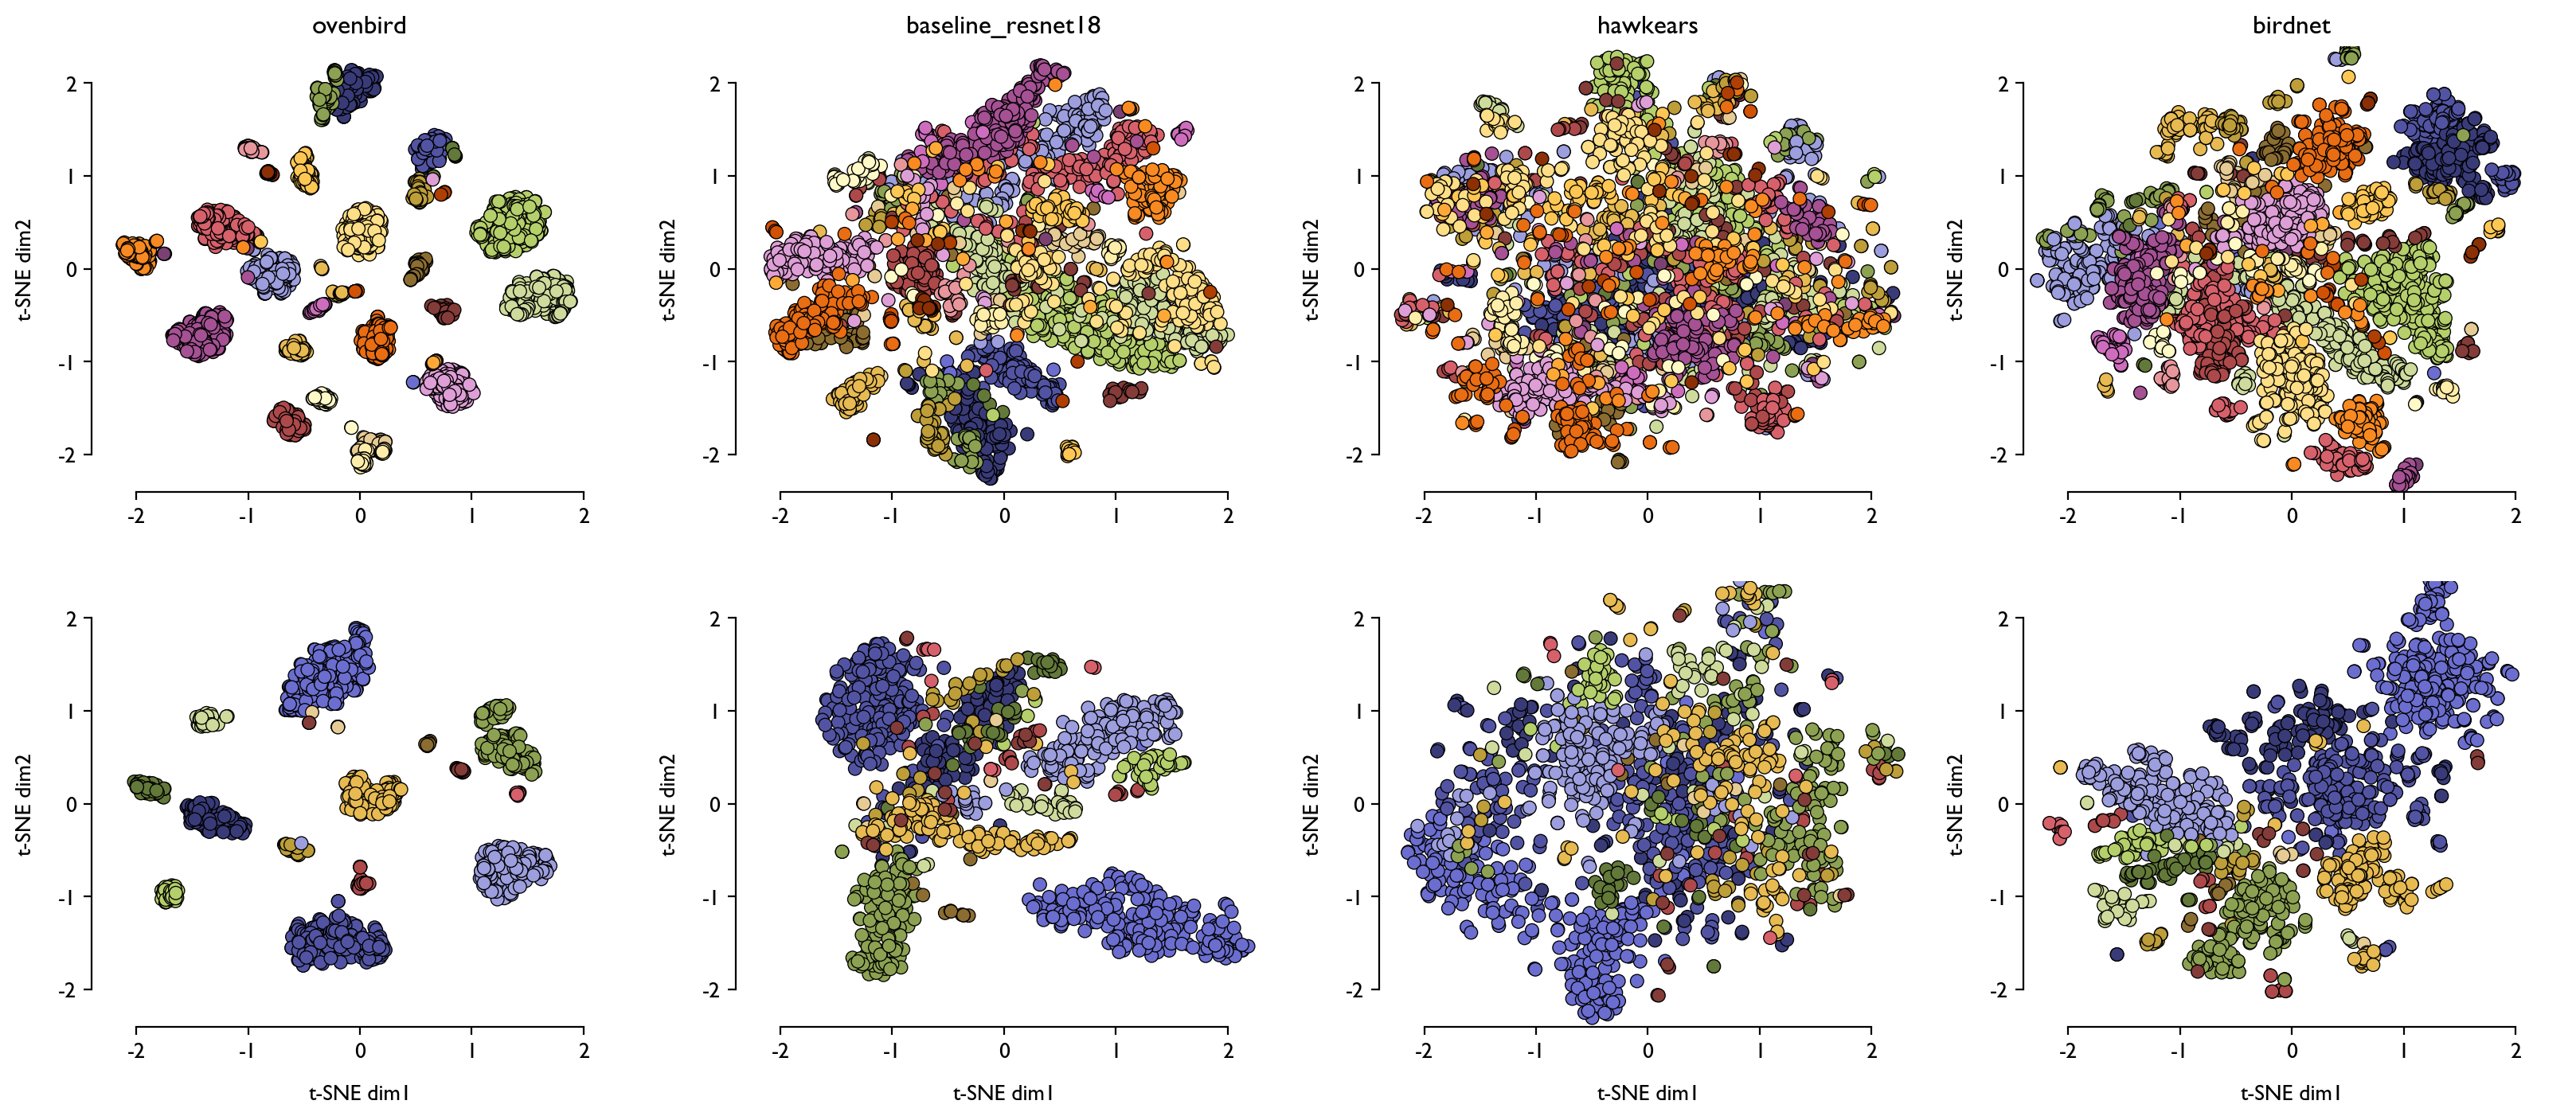

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
palette = sns.color_palette("tab20b") + sns.color_palette(palette="YlOrBr", n_colors=10)
sns.set_palette(palette)
for i, model in enumerate(models.keys()):
    ax = axs[0, i]
    g = sns.scatterplot(
        val_labels,
        # col="array",
        x=f"{model}_dim1",
        y=f"{model}_dim2",
        hue="aiid_label",
        edgecolor="#000000",
        ax=ax,
        palette=palette,
        # size="distance_to_mic_m",
        # palette=palette,
        # col_wrap=4,
    )
    ax.set_title(model)
    ax.set_xlabel(None)
    ax.set_ylabel(f"t-SNE dim2")

    import tuftelike

    tuftelike.adjust([-2, 2], [-2, 2], ax=ax)
    ax.legend_.remove()

# test set
for i, model in enumerate(models.keys()):
    ax = axs[1, i]
    g = sns.scatterplot(
        test_labels,
        # col="array",
        x=f"{model}_dim1",
        y=f"{model}_dim2",
        hue="aiid_label",
        edgecolor="#000000",
        ax=ax,
        palette=palette,
        # size="distance_to_mic_m",
        # palette=palette,
        # col_wrap=4,
    )
    # ax.set_title(model)
    ax.set_xlabel(f"t-SNE dim1")
    ax.set_ylabel(f"t-SNE dim2")

    import tuftelike

    tuftelike.adjust([-2, 2], [-2, 2], ax=ax)
    ax.legend_.remove()
plt.savefig(f"../../figures/Figure5_tsne_clusters.pdf")

In [11]:
# plot labels produced by the models

In [12]:
# cluster the validation set embeddings, assigning labels
for i, (model, embeddings) in enumerate(validation_set_embeddings.items()):
    labels, features = evaluation.cluster(
        val_labels,
        embeddings,
        min_cluster_size=7,
        reduced_n_dimensions=3,
        reduction_algorithm="tsne",
    )
    val_labels[f"{model}_label"] = labels

In [13]:
# cluster the test set embeddings, assigning labels
for i, (model, embeddings) in enumerate(test_set_embeddings.items()):
    labels, features = evaluation.cluster(
        test_labels,
        embeddings,
        min_cluster_size=7,
        reduced_n_dimensions=3,
        reduction_algorithm="tsne",
    )
    test_labels[f"{model}_label"] = labels

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_77266/241402835.py:10: UserWarning: The palette list has more values (31) than needed (27), which may not be intended.
  g = sns.scatterplot(
/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_77266/241402835.py:10: UserWarning: The palette list has more values (31) than needed (4), which may not be intended.
  g = sns.scatterplot(
/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_77266/241402835.py:10: UserWarning: The palette list has more values (31) than needed (5), which may not be intended.
  g = sns.scatterplot(
/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_77266/241402835.py:10: UserWarning: 
The palette list has fewer values (31) than needed (48) and will cycle, which may produce an uninterpretable plot.
  g = sns.scatterplot(
/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_77266/241402835.py:34: UserWarning: The palette list has more values (31) than needed (15), which may not 

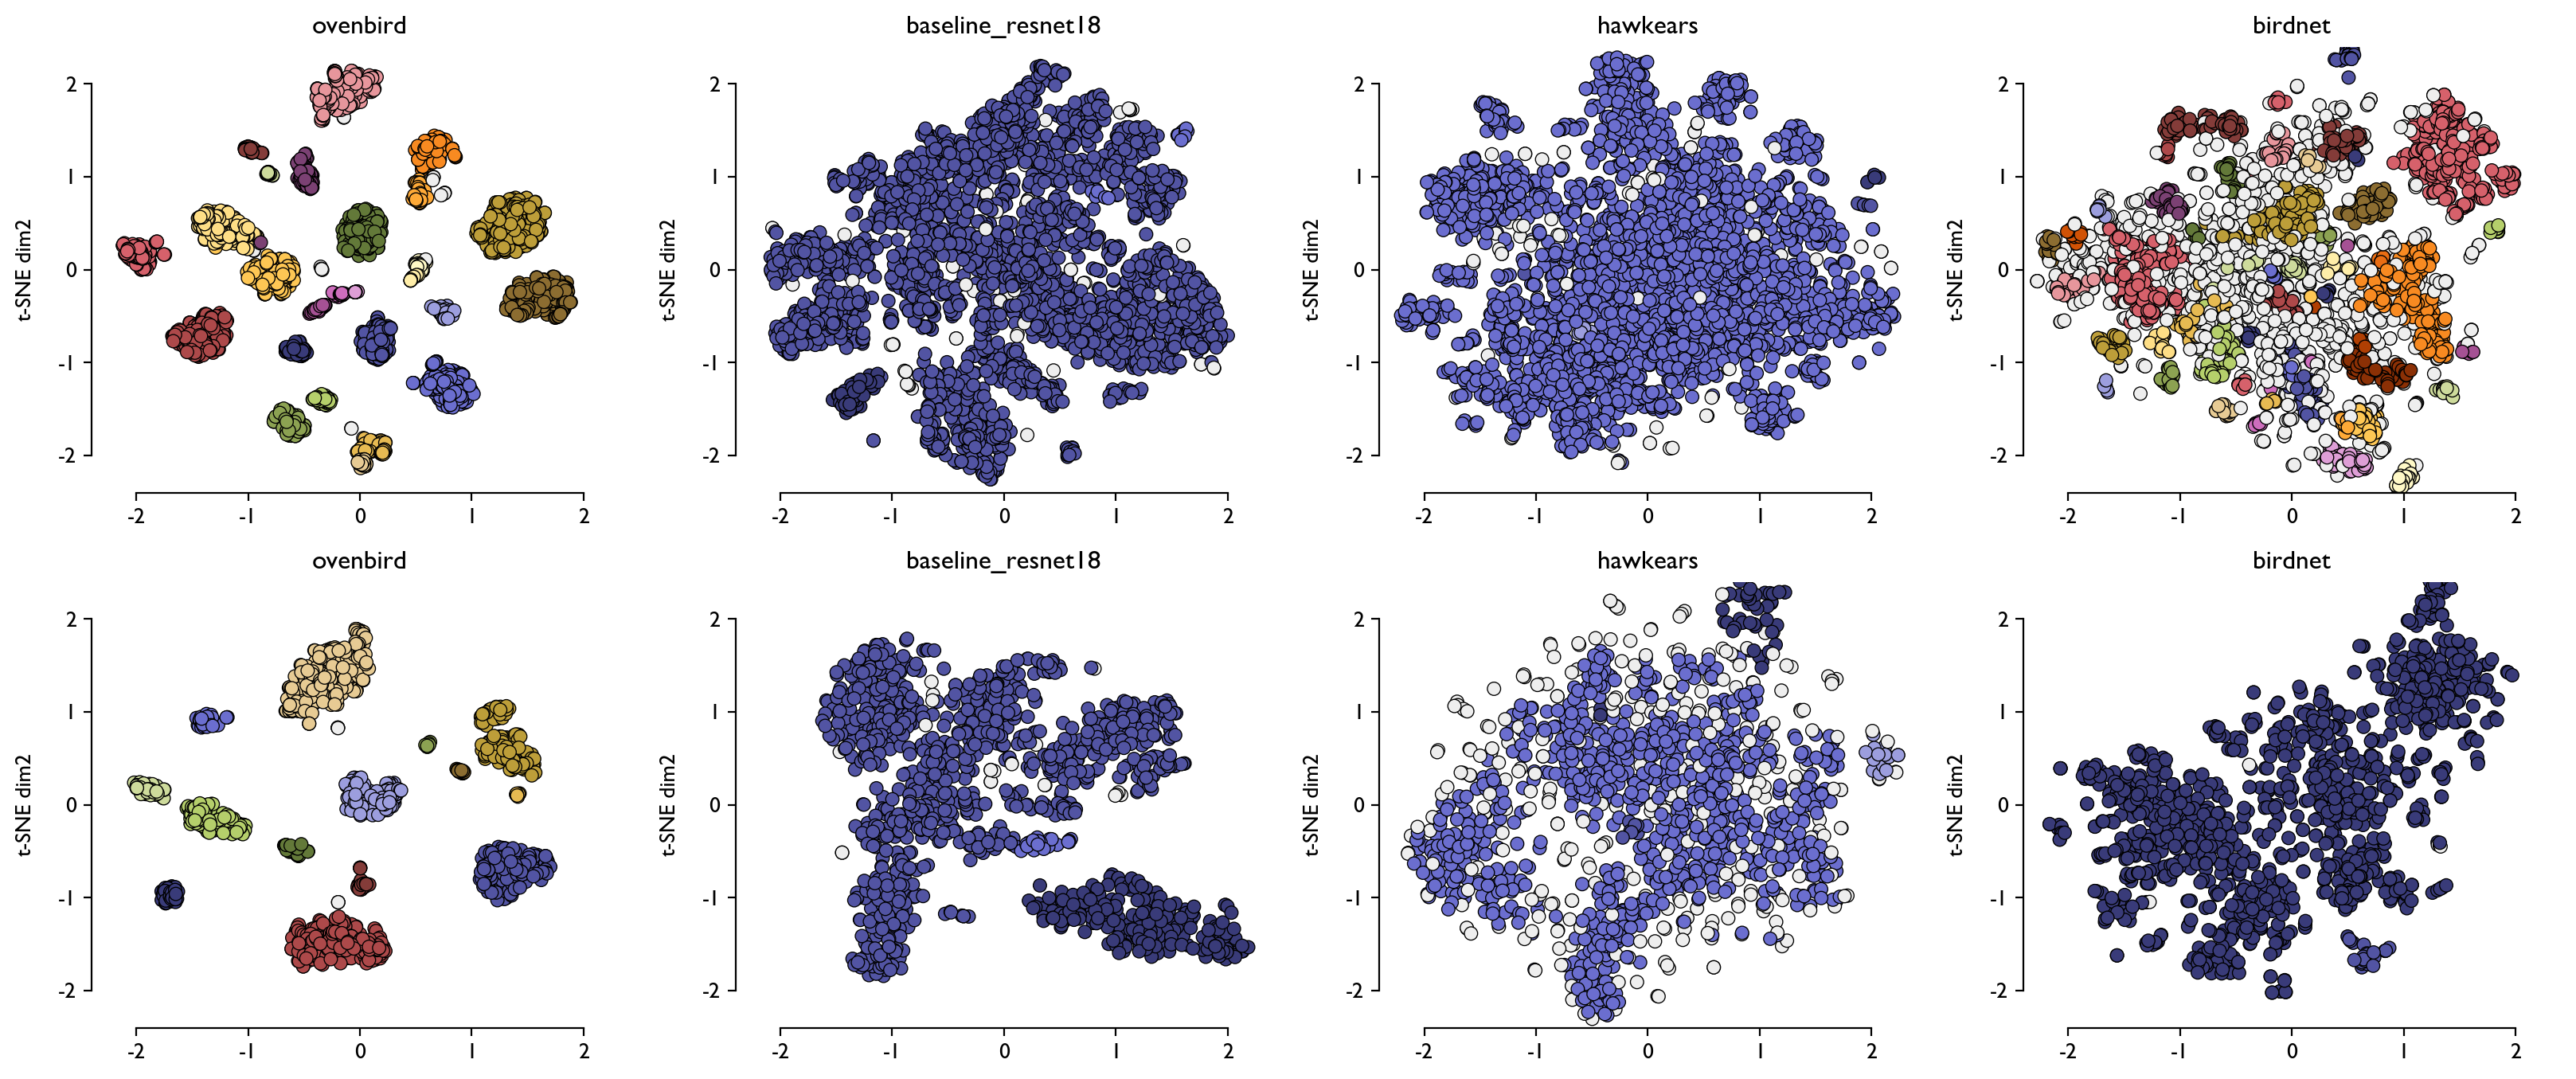

In [14]:
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
palette = (
    ["#EEEEEE"]
    + sns.color_palette("tab20b")
    + sns.color_palette(palette="YlOrBr", n_colors=10)
)
sns.set_palette(palette)
for i, model in enumerate(models.keys()):
    ax = axs[0, i]
    g = sns.scatterplot(
        val_labels,
        # col="array",
        x=f"{model}_dim1",
        y=f"{model}_dim2",
        hue=f"{model}_label",  # "aiid_label",
        edgecolor="#000000",
        ax=ax,
        palette=palette,
        # size="distance_to_mic_m",
        # palette=palette,
        # col_wrap=4,
    )
    ax.set_title(model)
    ax.set_xlabel(None)
    ax.set_ylabel(f"t-SNE dim2")

    import tuftelike

    tuftelike.adjust([-2, 2], [-2, 2], ax=ax)
    ax.legend_.remove()

for i, model in enumerate(models.keys()):
    ax = axs[1, i]
    g = sns.scatterplot(
        test_labels,
        # col="array",
        x=f"{model}_dim1",
        y=f"{model}_dim2",
        hue=f"{model}_label",  # "aiid_label",
        edgecolor="#000000",
        ax=ax,
        palette=palette,
        # size="distance_to_mic_m",
        # palette=palette,
        # col_wrap=4,
    )
    ax.set_title(model)
    ax.set_xlabel(None)
    ax.set_ylabel(f"t-SNE dim2")

    import tuftelike

    tuftelike.adjust([-2, 2], [-2, 2], ax=ax)
    ax.legend_.remove()
plt.savefig("../../figures/FigureS7_val_and_test_sets_aiid_clustering.pdf")